### Score Class Activation Map
##### Score-CAM is used to explain how KyleNet makes its decisions. The code has been taken and adapted from: https://github.com/tabayashi0117/Score-CAM to fit a sigmoid CNN model that doesn't use ImageNet weights

##### Score-CAM Procedure:
###### 1. Up-sample the output of final conv layer to original input size
###### 2. Normalize the raw activation value in each activation map into [0, 1]
###### 3. Project the highlighted area in the activation map to original input space by multiplying the normalized activation map
###### 4. Feed the masked inputs into CNN model and sigmoid
###### 5. Define the weight as the score of the target class in the prediction
###### 6. Get the final class discriminative localization map as the linear weighted combination of all activation maps

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras_preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model, Model

##### Load the Best Model from the KyleNet Experiments

In [2]:
model_path = Path(".").resolve().parent.joinpath("models/Experiment 4.h5")
model = load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

##### Configuration Options

In [3]:
img_path = "../dataset/COVID-19/137covid_patient84_SR_3_IM00015.png"
img_array = np.array(load_img(img_path), dtype=np.uint8)

##### Function to Show Images

In [4]:
def show_image(image_array):
    plt.imshow(image_array)
    plt.axis("off")
    plt.show()

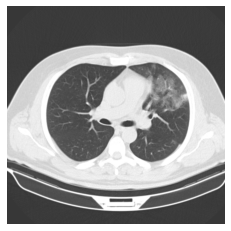

In [5]:
# Show original image
show_image(img_array)

##### ScoreCam Algorithm

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class ScoreCAM:
    def __init__(self, image):
        self.model = load_model("../models/Experiment 4.h5")
        self.final_conv = "conv2d_5"

        self.image = image
        self.img_array = self.read_and_preprocess_img()

        self.heatmap = None
        self.cam_superimposed = None

    def cam(self, max_n=-1):
        act_map_array = Model(inputs=self.model.input,
                              outputs=self.model.get_layer(self.final_conv).output).predict(self.img_array)

        # Extract effective maps
        if max_n != -1:
            act_map_std_list = [np.std(act_map_array[0, :, :, k]) for k in range(act_map_array.shape[3])]
            unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_n)[:max_n]
            max_n_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
            act_map_array = act_map_array[:, :, :, max_n_indices]

        # 1. Up-sample the output of final conv layer to original input size
        input_shape = self.model.layers[0].input_shape[1:]
        act_map_resized_list = [cv2.resize(act_map_array[0, :, :, k], input_shape[:2], interpolation=cv2.INTER_LINEAR)
                                for k in range(act_map_array.shape[3])]

        # 2. Normalize the raw activation value in each activation map into [0, 1]
        act_map_normalized_list = []
        for act_map_resized in act_map_resized_list:
            if np.max(act_map_resized) - np.min(act_map_resized) != 0:
                act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
            else:
                act_map_normalized = act_map_resized
            act_map_normalized_list.append(act_map_normalized)

        # 3. Project the highlighted area in the activation map to original input space by multiplying
        # the normalized activation map
        masked_input_list = []
        for act_map_normalized in act_map_normalized_list:
            masked_input = np.copy(self.img_array)

            for k in range(3):
                masked_input[0, :, :, k] *= act_map_normalized
            masked_input_list.append(masked_input)
        masked_input_array = np.concatenate(masked_input_list, axis=0)

        # 4. Feed the masked inputs into CNN model and sigmoid
        pred_from_masked_input_array = (sigmoid(self.model.predict(masked_input_array)) > 0.5).astype("int")

        # 5. Define the weight as the score of the target class in the prediction
        weights = pred_from_masked_input_array[:, 0]

        # 6. Get the final class discriminative localization map as the linear weighted combination
        # of all activation maps
        self.heatmap = np.dot(act_map_array[0, :, :, :], weights)
        self.heatmap = np.maximum(0, self.heatmap)  # passing through ReLU
        self.heatmap /= np.max(self.heatmap)  # scale 0 to 1.0

        return self.heatmap

    def read_and_preprocess_img(self):
        img = load_img(self.image, target_size=(224, 224))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        return img

    def superimpose(self, emphasize=True):
        img_bgr = cv2.imread(self.image)

        heatmap = cv2.resize(self.heatmap, (img_bgr.shape[1], img_bgr.shape[0]))
        if emphasize:
            heatmap = 1 / (1 + np.exp(-50 * (heatmap - 0.5)))  # sigmoid
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        hif = 0.8
        self.cam_superimposed = heatmap * hif + img_bgr
        self.cam_superimposed = np.minimum(self.cam_superimposed, 255.0).astype(np.uint8)  # scale 0 to 255
        self.cam_superimposed = cv2.cvtColor(self.cam_superimposed, cv2.COLOR_BGR2RGB)

        return self.cam_superimposed

##### Build the Heatmap

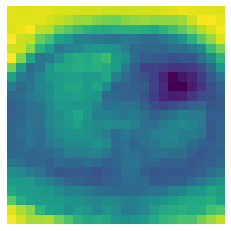

In [10]:
score_cam = ScoreCAM(img_path)
heatmap = score_cam.cam()
show_image(heatmap)

##### Superimpose the Heatmap onto the Image

In [11]:
score_cam_superimposed = score_cam.superimpose(emphasize=False)
score_cam_emphasized = score_cam.superimpose(emphasize=True)

(512, 512, 3)
(512, 512, 3)


##### Show All the Images

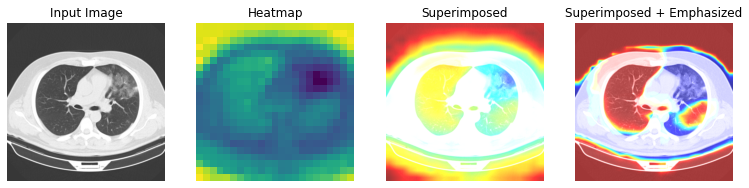

In [69]:
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(13, 11))
ax[0].imshow(img_array)
ax[0].set_title("Input Image")
ax[1].imshow(heatmap)
ax[1].set_title("Heatmap")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Superimposed")
ax[3].imshow(score_cam_emphasized)
ax[3].set_title("Superimposed + Emphasized")

for ax in fig.axes:
    ax.axis("off")

plt.savefig("../images/Score-CAM.png")
plt.show()